In [ ]:
import pandas as pd
import sys
import os
import numpy as np
import cupy as cp
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.kernel_ridge import KernelRidge
from timeit import default_timer as timer 
from sys import getsizeof
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True)

In [ ]:


def pivoted_cholesky(matrix, max_rank, diag_rtol=1e-3, name=None):
    
    norm_array = []
    rank_array = []
    time_array = []
    
    if max_rank > np.linalg.matrix_rank(matrix):
        max_rank = np.linalg.matrix_rank(matrix)
    
    matrix_shape = np.asarray(matrix.shape)
    matrix_diag = np.diagonal(matrix)
    orig_error = np.amax(matrix_diag)
    
    Error_array = []
    norm_array = []
    
    start = timer()
    
    def body(m, pchol, perm, matrix_diag):
        
        maxi = np.argmax(matrix_diag[perm[m:]]) + m

        maxval = matrix_diag[perm][maxi]
        perm[m], perm[maxi] = perm[maxi], perm[m]

        row = matrix[perm[m]][perm[m + 1:]]

        
        def batch_gather(params, indices, axis=-1):
            return np.take(params, indices, axis=axis)
        

        prev_rows = pchol[..., :m, :]
        prev_rows_perm_m_onward = batch_gather(prev_rows, perm[..., m + 1:])
        prev_rows_pivot_col = batch_gather(prev_rows, perm[..., m:m + 1])
        
        row -= np.sum(prev_rows_perm_m_onward * prev_rows_pivot_col, axis = -2)

        pivot = np.sqrt(maxval)
        
        row /= pivot

        row = np.concatenate([[pivot], row], -1)
        
        matrix_diag_copy = matrix_diag.copy()
        matrix_diag_copy[perm[m:]] -= row**2
        
        pchol[m, perm[m:]] = row
        pchol_shape = pchol.shape

        return m + 1, pchol, perm, matrix_diag_copy

    m = np.int64(0)
    pchol = np.zeros(matrix_shape, dtype=matrix.dtype)[..., :max_rank, :]
    perm = np.broadcast_to(
        range(matrix_shape[-1]), matrix_shape[:-1])
    perm = perm.copy()

    def check_cond(m, pchol, perm, matrix_diag):
        del pchol
        del perm
        error = np.linalg.norm(matrix_diag, ord=1, axis=-1)
        max_error = np.amax(error / orig_error)
        return (m >= max_rank)

    while(1):
        m, pchol, perm, matrix_diag = body(m, pchol, perm, matrix_diag)
        pchol_T = np.transpose(pchol)
        lr_approx = np.matmul(pchol, pchol_T)
        time_array.append(timer() - start) 
        rank_array.append(np.linalg.matrix_rank(lr_approx))
        norm_array.append(np.linalg.norm(lr_approx))
        if (m % 50 == 0):
            print(m)
        if check_cond(m, pchol, perm, matrix_diag):
            break

#     pchol_T = np.transpose(pchol)
#     lr_approx = np.matmul(pchol, pchol_T)
    

    return lr_approx, rank_array, norm_array, time_array


In [ ]:



def pivoted_cholesky_gpu(matrix, max_rank,  diag_rtol=1e-3, name=None):
    
    norm_array_gpu = []
    rank_array_gpu = []
    time_array_gpu = []

    if max_rank > np.linalg.matrix_rank(matrix):
            max_rank = np.linalg.matrix_rank(matrix)
    
    matrix_shape = np.asarray(matrix.shape)
    matrix_diag = cp.diagonal(matrix)
    orig_error = cp.amax(matrix_diag)
    max_rank = cp.asnumpy(max_rank)
    
    start = timer()

    def body(m, pchol, perm, matrix_diag):

        maxi = np.argmax(matrix_diag[perm[m:]]) + m

        maxval = matrix_diag[perm][maxi]
        perm[m], perm[maxi] = perm[maxi], perm[m]

        row = matrix[perm[m]][perm[m + 1:]]

        # row = cp.array(row)
        pchol = cp.asnumpy(pchol)

        
        def batch_gather(params, indices, axis=-1):
            return cp.take(params, indices, axis=axis)
        

        prev_rows = pchol[..., :m, :]
        prev_rows_perm_m_onward = batch_gather(prev_rows, perm[..., m + 1:])
        prev_rows_pivot_col = batch_gather(prev_rows, perm[..., m:m + 1])
        
        row -= cp.sum(prev_rows_perm_m_onward * prev_rows_pivot_col, axis = -2)
        pivot = np.sqrt(maxval)

        row /= pivot
        row = np.concatenate(([pivot], row), -1)
        
        matrix_diag_copy = matrix_diag.copy()
        matrix_diag_copy[perm[m:]] -= row**2
        
        pchol[m, perm[m:]] = row
        pchol_shape = pchol.shape

        return m + 1, pchol, perm, matrix_diag_copy

    m = cp.int64(0)
    pchol = cp.zeros(matrix_shape, dtype=matrix.dtype)[..., :max_rank, :]
    perm = np.broadcast_to(
        range(matrix_shape[-1]), matrix_shape[:-1])
    perm = perm.copy()

    def check_cond(m, pchol, perm, matrix_diag):
        del pchol
        del perm
        error = np.linalg.norm(matrix_diag, ord=1, axis=-1)
        max_error = cp.amax(error / orig_error)
        return (m >= max_rank)

    while(1):
        m, pchol, perm, matrix_diag = body(m, pchol, perm, matrix_diag)
        pchol = cp.array(pchol)
        pchol_T = cp.transpose(pchol)
        lr_approx = cp.matmul(pchol, pchol_T)
        time_array_gpu.append(timer() - start)  
        rank_array_gpu.append(np.linalg.matrix_rank(lr_approx))
        norm_array_gpu.append(np.linalg.norm(lr_approx))
#         print("m = ", m)
        if (m % 100 == 0):
            print(m)
        
        if check_cond(m, pchol, perm, matrix_diag):
            break
            

    return lr_approx, rank_array_gpu, norm_array_gpu, time_array_gpu

In [ ]:
import pandas as pd
energy_set = pd.read_csv('energy.csv')

energy_set.shape


X = pd.read_csv('energy.csv', usecols=['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'])
y = pd.read_csv('energy.csv', usecols=['Y1'])

X = X.values
y = y.values

start_load = timer()

# X = np.load('data/md17_X.npy')

# y = np.load('data/md17_Y.npy')

print("CPU load data time = ", timer() - start_load)


In [ ]:
kernel_matrix.shape
X = X[:60]
y = y[:60]

In [ ]:

X = X[:3000]
y = y[:3000]
X.shape,  y.shape



In [ ]:
start_km = timer()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

kernel_matrix = sklearn.metrics.pairwise.laplacian_kernel(X_train, Y=None, gamma=None)

print("CPU kernel_Matrix init time = ", timer() - start_km)
kernel_matrix.shape

kernel_matrix.shape, np.linalg.norm(kernel_matrix)

In [ ]:
def execute_krr(matrix, ridge_parameter, X_train, y_train, X_test):

#   lr_approx_ridge = matrix + np.identity(len(X_train)) * ridge_parameter
    lr_approx_ridge = matrix + np.identity(len(matrix)) * ridge_parameter
    
    alpha = np.linalg.solve(lr_approx_ridge, y_train)

    pred = 0
    y_prediction = []

    for j in range(len(X_test)):
        x_test_val = X_test[j].reshape(1,-1)
        pred = 0
        for i in range(len(X_train)):
            x_train_val = X_train[i].reshape(1,-1)
            temp = alpha[i] * sklearn.metrics.pairwise.laplacian_kernel(x_train_val, x_test_val)     
            pred += temp[0]
        y_prediction.append(pred[0])


    y_predarray = np.array(y_prediction).reshape(-1,1)
    y_predarray.shape
    return y_predarray

In [ ]:
kernel_matrix.shape

In [ ]:
def execute_krr_gpu(matrix, ridge_parameter, X_train, y_train, X_test):
    
    
#     a = cp.identity(len(X_train))
    lr_approx_ridge = matrix + cp.identity(len(X_train)) * ridge_parameter
    
#     print(type(lr_approx_ridge), np.linalg.matrix_rank(lr_approx_ridge), type(y_train))
    alpha = cp.linalg.solve(lr_approx_ridge, y_train)

    y_prediction = []
    
    X_train, X_test = cp.asnumpy(X_train), cp.asnumpy(X_test)
    for j in range(len(X_test)):
        x_test_val = X_test[j].reshape(1,-1)
        pred = 0
        for i in range(len(X_train)):
            x_train_val = X_train[i].reshape(1,-1)
            similarity = cp.array(sklearn.metrics.pairwise.laplacian_kernel(x_train_val, x_test_val))     
            temp = alpha[i][0] * similarity[0]     
            pred += temp[0]
        y_prediction.append(pred)


#     y_predarray = np.array(y_prediction).reshape(-1,1)
#     y_predarray.shape
    print(type(y_prediction))
    return cp.asarray(y_prediction)

In [ ]:
len(X_test),

In [ ]:
lr_approx = pivoted_cholesky(kernel_matrix, 10000) 

# lr_approx[3][2990:]
# lr_approx[0]

In [ ]:
lr_approx_gpu = pivoted_cholesky_gpu(kernel_matrix, 10000) 

# lr_approx_gpu[3][9000:]
kernel_matrix.shape

In [ ]:
lr_approx_gpu[2][:48]

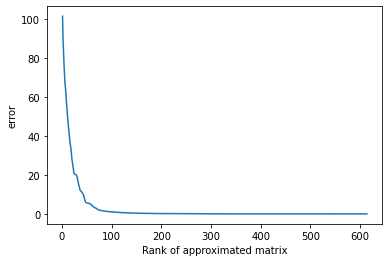

FileNotFoundError: [Errno 2] No such file or directory: 'figs/energy_rank_error.png'

<Figure size 432x288 with 0 Axes>

In [354]:
# for tcpu, tgpu in zip(cpu_pivtime_array,gpu_pivtime_array):
#     print(tcpu, tgpu)
    
# plt.title("Matplotlib demo") 
plt.xlabel("Rank of approximated matrix") 
plt.ylabel("error") 

# # print(type(lr_approx_gpu[1]), type(lr_approx_gpu[2]))
# plot_x1 = np.asarray(lr_approx[1])
# plot_y2 = np.asarray(lr_approx[2])
# plot_y3 = np.asarray(lr_approx_gpu[2])

# plt.plot(plot_x1, plot_y2, plot_y3)


orig_norm = np.linalg.norm(kernel_matrix)
plt.plot(lr_approx[1], orig_norm - lr_approx[2])
plt.show()
plt.savefig('figs/energy_rank_error.png')

lr_approx_gpu[2]

np.linalg.norm(kernel_matrix) - lr_approx[2]

# lr_approx[2]
lr_approx_gpu_norms =  []

for val in lr_approx_gpu[2]:
    lr_approx_gpu_norms.append(val)


In [ ]:
start_krr_cpu = timer()


y_predarray = execute_krr(lr_approx[0], 0, X_train, y_train, X_test)

print("krr_cpu = ", timer() - start_krr_cpu)

start_krr_cpu = = timer()

y_predarray_gpu = execute_krr_gpu(lr_approx[0], 3, X_train, y_train, X_test)

print("krr_cpu = ", timer() - start_krr_gpu)

print("CPU krr full= ", timer() - start_krr_full)

for y1, y2, y3 in zip(y_test, y_predarray, y_predarray_gpu):
    print(y1, y2, y3)


In [ ]:
start_krr_full = timer()

X_train_cp, y_train_cp, X_test_cp, y_test_cp, kernel_matrix_cp = cp.array(X_train), cp.array(y_train), cp.array(X_test), cp.array(y_test), cp.array(kernel_matrix)

y_predarray_gpu = execute_krr_gpu(lr_approx_gpu, 0, X_train_cp, y_train_cp, X_test_cp)

print("GPU krr full= ", timer() - start_krr_full)

for y1, y2, y3 in zip(y_test, y_predarray, y_predarray_gpu):
    print(y1, y2, y3)

In [ ]:
lr_approx[0].shape

np.linalg.norm(kernel_matrix), np.linalg.norm(lr_approx[0])

In [ ]:
np.linalg.matrix_rank(lr_approx)

In [ ]:
krr_laplacian = KernelRidge(alpha=0, kernel='laplacian')
# X_train_stan, y_train_stan = cp.asnumpy(X_train), cp.asnumpy(y_train)
# X_test_stan, y_test_stan = cp.asnumpy(X_test), cp.asnumpy(y_test)
krr_laplacian.fit(X_train, y_train)


stan_pred = krr_laplacian.predict(X_test)
# stan_pred = []

rsme_krr_standard = np.sqrt(mean_squared_error(y_test, stan_pred))
# rsme_krr_standard = 100
rsme_krr_manual = np.sqrt(mean_squared_error(y_test, y_predarray))
    
print("rsme_sk = ", rsme_krr_standard, "rsme_piv = ", rsme_krr_manual, "\n")

print(y_test.shape)

for y1, y2, y3 in zip(stan_pred, y_predarray, y_test):
    print(y1, "    ", y2, "     ", y3)

In [ ]:
for y1, y2 in zip(y_predarray2, y_test):
    print(y1, "    ", y2)

In [ ]:
#60 samples from energy_efficiency. 48:12 training - testing split

kernel_matrix.shape
    

#sklearn krr, #manual    #actual values
#RANK 46